In [1]:
import numpy as np
import constants
import matplotlib.pyplot as plt

In [138]:
def _Newton(e, M, accuracy, initial = 0):
    # Solves Kepler equation. Mustn't be called on it's own
    # To calculate true/eccentricity anomalies call KeplerSolver
    # Returns E or H or v (for elliptic, hyperbolic and parabolic orbits accordingly) in radians
    
    p2 = 2 * np.pi
    # Elliptic orbit
    if e < 1 - constants.max_to_zero:
        M = np.abs(M) % p2 * np.sign(M)
        if M > np.pi:
            M = M - p2
        elif M < -np.pi:
            M = p2 +M
        E2 = initial
        E1 = 2 * accuracy + E2
        while abs(E2 - E1) > accuracy:
            E1 = E2
            E2 = E1 - (E1 - e * np.sin(E1) - M) / (1 - e * np.cos(E1))
        return E2
    # Hyperbolic orbit
    elif e >= 1 + constants.max_to_zero:
        H2 = initial
        H1 = 2 * accuracy + H2
        while abs(H2 - H1) > accuracy:
            H1 = H2
            H2 = H1 - (e * np.sinh(H1) - H1 - M) / (e * np.cosh(H1) - 1)
        return H2
    # Parabolic orbit
    else:
        # Designate x = tg(v/2), then according ot wolfram aplpha here is an exact real solution
        b = np.power(np.sqrt(9 * M**2 + 1) + 3 * M, 1/3)
        x = b - 1 / b
        return 2 * np.arctan(x)
        
def KeplerSolver(a, e, t, epoch = 0, M0 = 0, mu = constants.muE, accuracy = constants.max_to_zero):
    # e - eccentricity
    # a - major semi-axis in meters; If e == 1 (parabolic orbit) a is assumed to be p (focal prarameter)
    # t - time at which E is wanted in seconds
    # t can be float or iterable array. In case of iterable array it is assumed to be in ascending order
    # epoch - time of mesaurments of M0, zero by default
    # M0 - mean anomaly (M = M0 + (t - epoch)/T), zero by default
    # mu - standart gravitational parameter, Earths by default
    # accuracy - accuracy, it is empirically known that accuracy mustn't be bigger 1e-11 otherwise it will give wrong result
    # Returns v, E - true and eccentricity anomalies in radians. Can be single values as well as arrays. It depends on t
    
    
    iterable = False
    p2 = 2 * np.pi
    T = np.sqrt(a**3 / mu) # Actually this is the period/2pi
    
    # Have to know t is an array or a single value
    try:
        for i in t:
            iterable = True
            break
    except TypeError:
        iterable = False
    
    # Solving. For an array of times the initial approximation for Newton method is optimized.
    if(iterable):
        previous = 0
        E = []
        
        for i in t:
            M = M0 + (i - epoch) / T
            previous = _Newton(e, M , accuracy, previous)
            E.append(previous)
        E = np.array(E)      
    else:
        M = M0 + (t - epoch) / T
        E = _Newton(e, M, accuracy)

    if e < 1 - constants.max_to_zero:
        v = 2 * np.arctan(np.sqrt((1 + e)/(1 - e)) * np.tan(E/2))
        return v, E
    elif e >= 1 + constants.max_to_zero:
        v = 2 * np.arctan(np.sqrt((e + 1)/(e - 1)) * np.tanh(E/2))
        return v, E
    else:
        return E, None

In [175]:
# Test for elliptic
p2 = 2 * np.pi
e = 0.3
a = constants.RE + constants.ISS_periapsis
T = np.sqrt(a**3 / constants.muE)
t = np.arange(0, (T * p2) * 0.99, 1)
v, E = KeplerSolver(a, e, t, accuracy = 1e-6)
f = np.abs(t / T) % p2 * np.sign(t / T)
for i in range(f.shape[0]):
    if f[i] > np.pi:
        f[i] = f[i] - p2
    elif f[i] < -np.pi:
        f[i] = p2 + f[i]
print("Max error:", np.max(np.abs(-e * np.sin(E) + E - f)))

Max error: 1.0325074129013956e-14


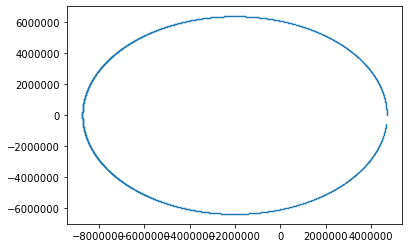

In [176]:
r = a * (1 - e**2) / (1 + e * np.cos(v))
x = r * np.cos(v)
y = r * np.sin(v)
plt.plot(x, y, 'o', ms = 0.2)

In [145]:
# Test for hyperbolic
e = 5
a = constants.RE + constants.ISS_periapsis
T = np.sqrt(a**3 / constants.muE)
t = np.arange(0, T, 1)
v, E = KeplerSolver(a, e, t, accuracy = 1e-6)
np.max(np.abs(e * np.sinh(E) - E - t / T))

4.440892098500626e-16

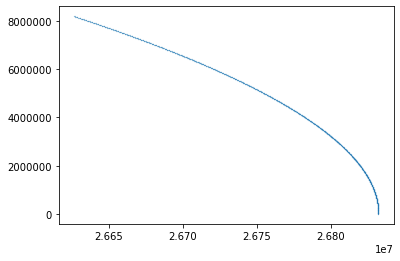

In [146]:
r = a * (e**2 - 1) / (1 + e * np.cos(v))
x = r * np.cos(v)
y = r * np.sin(v)
plt.plot(x, y, 'o', ms = 0.2)

In [148]:
# Test for parabolic
e = 1
a = constants.RE + constants.ISS_periapsis
T = np.sqrt((a/2)**3 / constants.muE)
t = np.arange(0, T, 1)
v, E = KeplerSolver(a / 2, e, t, accuracy = 1e-6)
np.max(np.abs(2 * t / T  - (np.tan(v/2) + np.tan(v/2)**3 / 3)))

1.3322676295501878e-15

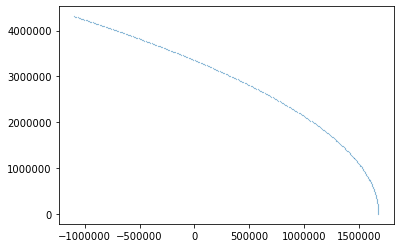

In [149]:
r = a / 2 / (1 + e * np.cos(v))
x = r * np.cos(v)
y = r * np.sin(v)
plt.plot(x, y, 'o', ms = 0.2)